# Dependencies

In [82]:
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import model_selection
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import warnings
warnings.filterwarnings("ignore")

from eli5 import explain_weights, show_weights
from yellowbrick import ROCAUC
from yellowbrick.classifier import ClassificationReport

In [83]:
print("All libraries imported successfully")

All libraries imported successfully


In [84]:
CV_N_REPEATS=5
BINS=10

# Load data

In [85]:
df = pd.read_csv("../../data/VLagun_Chem_Years3.csv")
df.head()

,SRP,DOP,PP,NH4N,NO3N,DON,PN,TN/TP,Fe,SiO4Si,DINtoDIP,Years
0,3.5,11.7,185.0,0.039,0.022,0.551,0.759,6.848152,0.0121,2.3112,17.428571,0
1,4.4,17.5,111.3,0.020,0.025,0.123,1.181,10.127628,0.0136,2.1157,10.227273,0
2,3.2,22.8,103.4,0.016,0.008,0.582,0.576,9.134467,0.0368,2.2641,7.500000,0
3,4.3,22.3,92.7,0.026,0.021,0.693,0.689,11.978206,0.0172,2.2623,10.930233,0
4,11.7,30.3,73.2,0.022,0.048,0.383,1.006,12.664931,0.0237,2.2164,5.982906,0


# Data shape

In [86]:
df.shape

(120, 12)

In [87]:
df.columns

Index(['SRP', 'DOP', 'PP', 'NH4N', 'NO3N', 'DON', 'PN', 'TN/TP', 'Fe',
       'SiO4Si', 'DINtoDIP', 'Years'],
      dtype='object')

# Chosen features chart

Text(0, 0.5, 'Years')

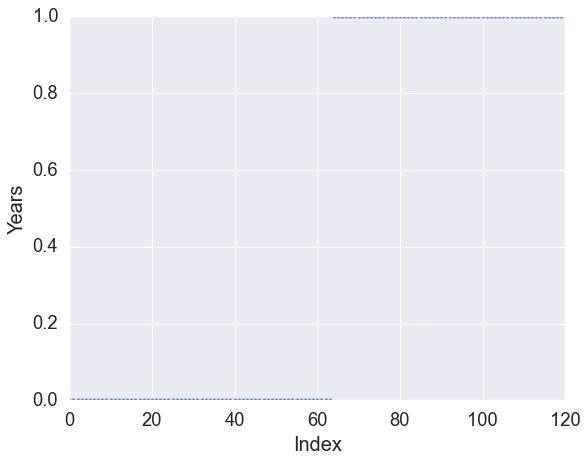

In [88]:
plt.figure()
plt.plot(df.Years,'.')
plt.xlabel('Index')
plt.ylabel('Years')

Text(0.5, 1.0, 'Seaborn countplot of Years rate within the dataset')

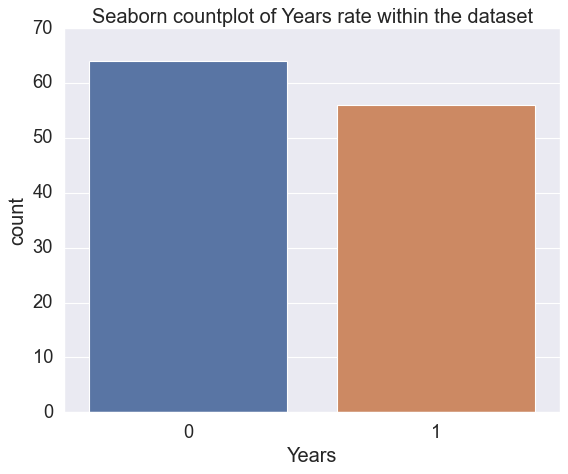

In [89]:
plt.figure()
ax =sns.countplot(data=df, x='Years')
ax.set_title('Seaborn countplot of Years rate within the dataset')

In [90]:
df.columns

Index(['SRP', 'DOP', 'PP', 'NH4N', 'NO3N', 'DON', 'PN', 'TN/TP', 'Fe',
       'SiO4Si', 'DINtoDIP', 'Years'],
      dtype='object')

# Box plots of the features and its years

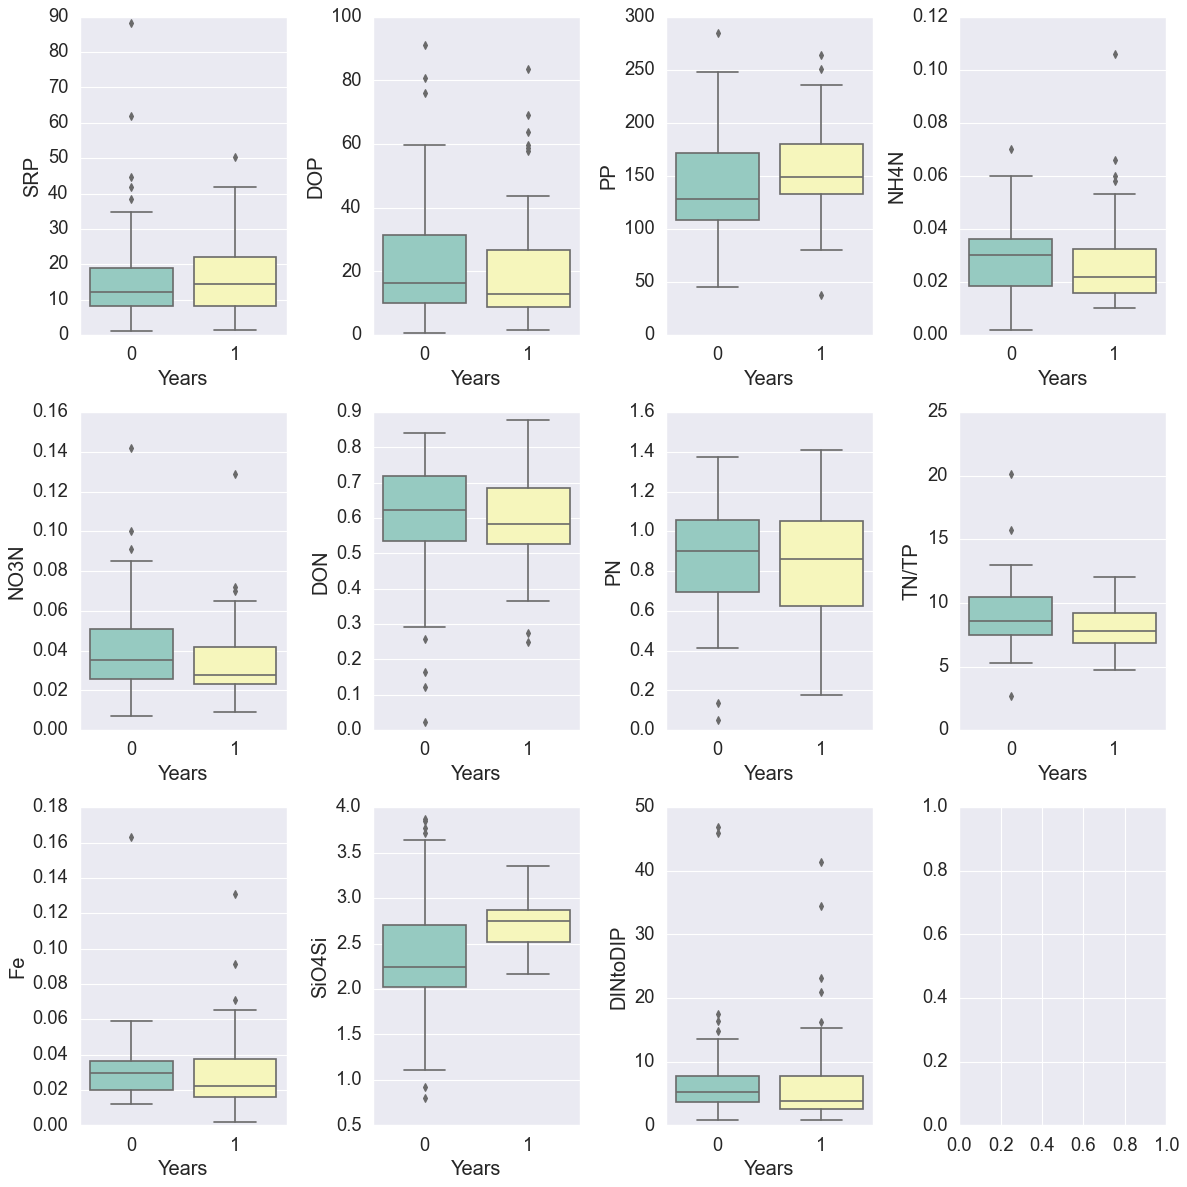

In [91]:
f, axes = plt.subplots(3,4,figsize=(15,15))
sns.set(style="white", palette="Set3", color_codes=True)
sns.boxplot(x="Years", y="SRP", data=df, orient='v', ax=axes[0,0])
sns.boxplot(x="Years", y="DOP", data=df, orient='v', ax=axes[0,1])
sns.boxplot(x="Years", y="PP", data=df, orient='v', ax=axes[0,2])
sns.boxplot(x="Years", y="NH4N", data=df, orient='v', ax=axes[0,3])
sns.boxplot(x="Years", y="NO3N", data=df, orient='v', ax=axes[1,0])
sns.boxplot(x="Years", y="DON", data=df, orient='v', ax=axes[1,1])
sns.boxplot(x="Years", y="PN", data=df, orient='v', ax=axes[1,2])
sns.boxplot(x="Years", y="TN/TP", data=df, orient='v', ax=axes[1,3])
sns.boxplot(x="Years", y="Fe", data=df, orient='v', ax=axes[2,0])
sns.boxplot(x="Years", y="SiO4Si", data=df, orient='v', ax=axes[2,1])
sns.boxplot(x="Years", y="DINtoDIP", data=df, orient='v', ax=axes[2,2])
f.subplots_adjust(left=0.008, right=0.98, top=0.9, bottom=0.05, hspace=0.4, wspace=0.3)
plt.tight_layout()

In [92]:
df_copy = df.copy(deep=True)
df_copy[['SRP', 'DOP', 'PP', 'NH4N', 'NO3N', 'DON', 'PN', 'TN/TP', 'Fe',
       'SiO4Si', 'DINtoDIP']] = df_copy[['SRP', 'DOP', 'PP', 'NH4N', 'NO3N', 'DON', 'PN', 'TN/TP', 'Fe',
       'SiO4Si', 'DINtoDIP']].replace(0,np.NaN)

print('Number of zero entries in each attribute:\n')
print(df_copy.isnull().sum())

Number of zero entries in each attribute:

SRP         0
DOP         0
PP          0
NH4N        0
NO3N        0
DON         0
PN          0
TN/TP       0
Fe          0
SiO4Si      0
DINtoDIP    0
Years       0
dtype: int64


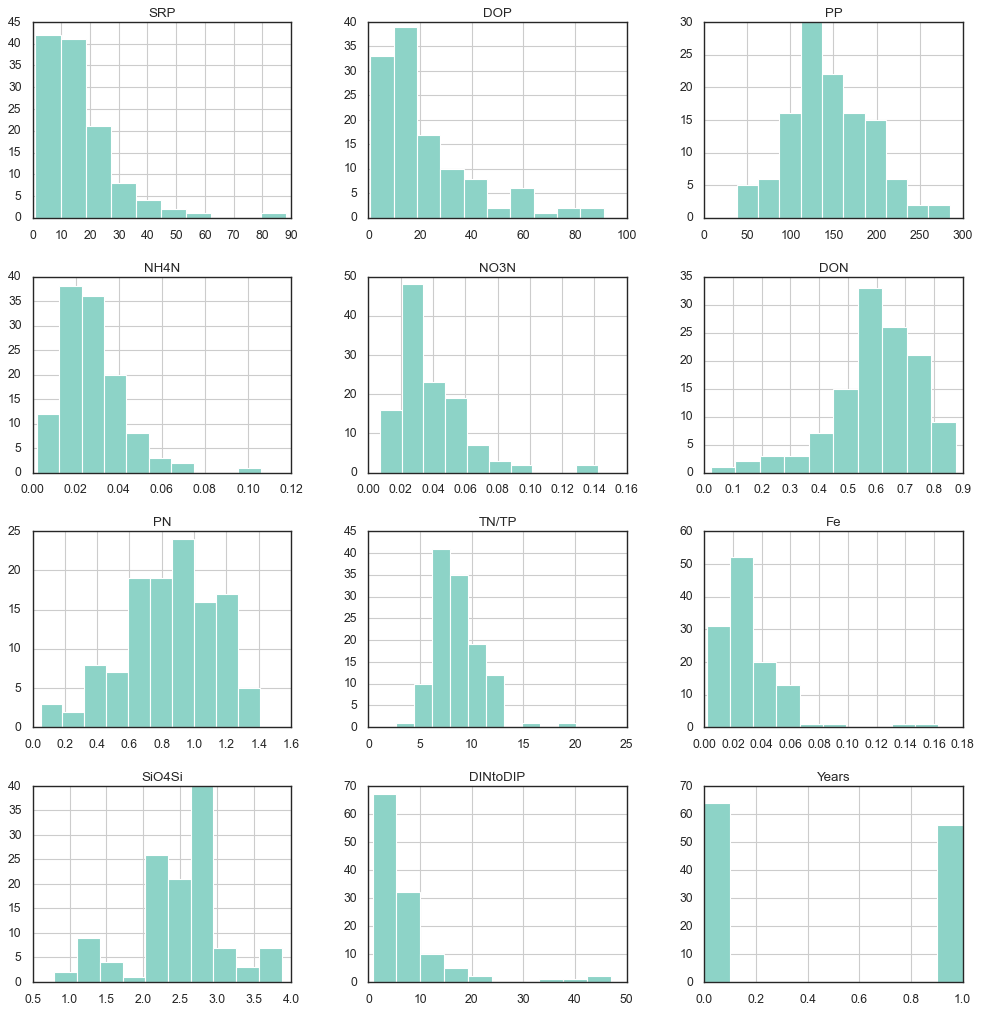

In [93]:
p = df.hist(figsize=(15,15))

# No replacing NaN needed

# Correlation plot

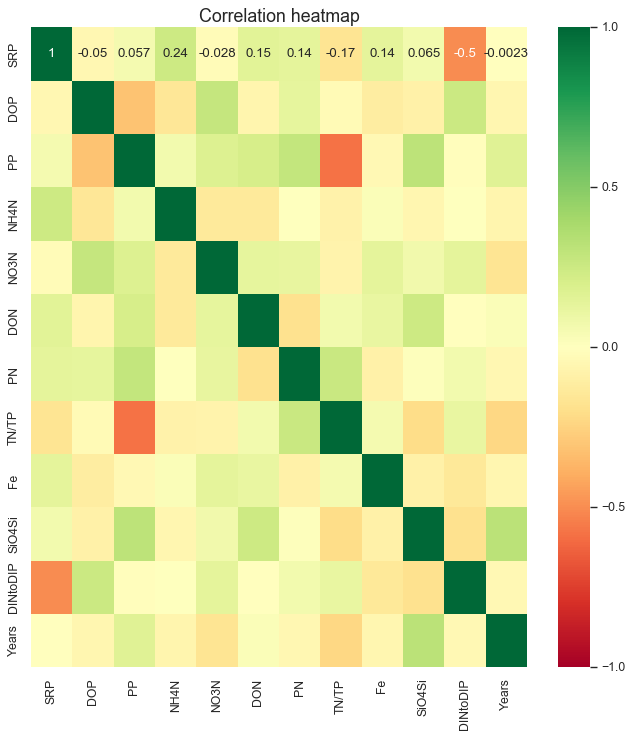

In [94]:
plt.figure(figsize=(10,10))
corr = df_copy.corr()
corr.index = df_copy.columns
sns.heatmap(corr, annot=True, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title("Correlation heatmap", fontsize=16)
plt.show()

<Figure size 640x480 with 0 Axes>

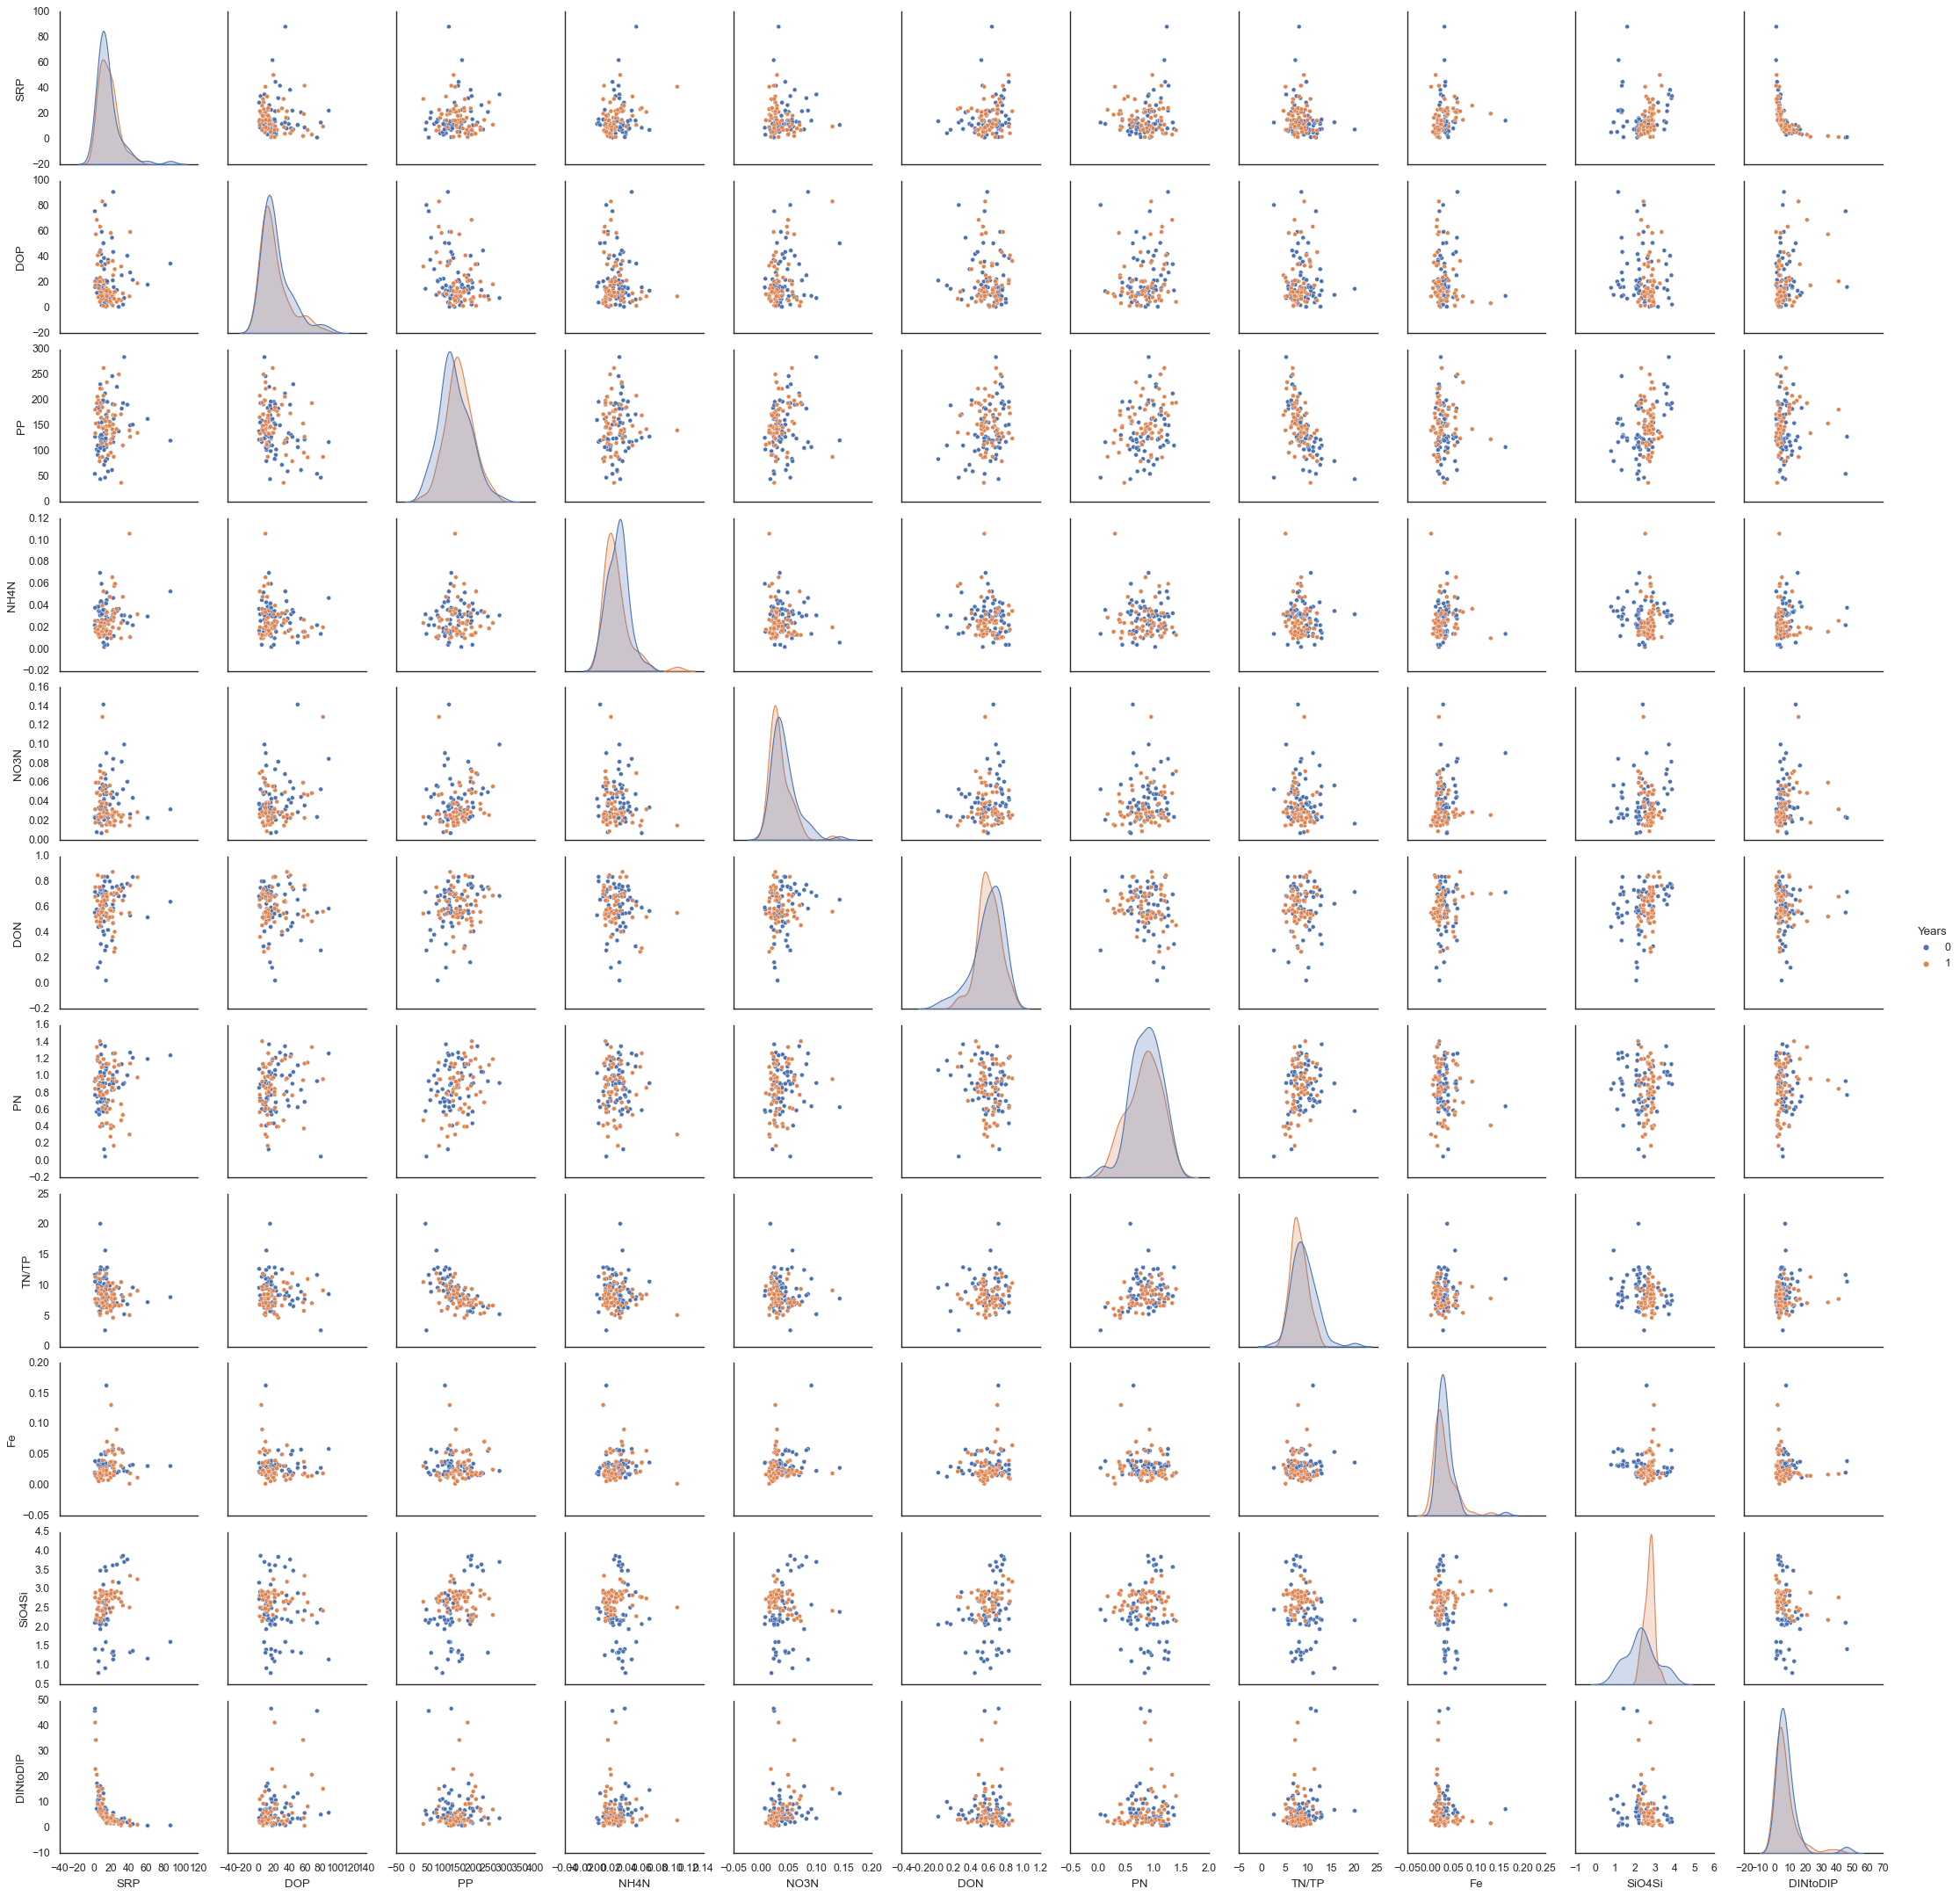

In [95]:
plt.figure()
sns.pairplot(df_copy, hue='Years', diag_kind='kde', palette='deep')

# PCA

In [96]:
X = df_copy.iloc[:,:11]
Y = df_copy.iloc[:,11]

# Standardazing the features

In [97]:
X = StandardScaler().fit_transform(X)

# Fit PCA

In [98]:
pca = PCA(n_components=.90)
pca.fit(X)
print("Variance explained by the principal components(in decreasing order)", pca.explained_variance_ratio_)
X1 = pca.transform(X)
print('Shape of transformed X:', X1.shape)

Variance explained by the principal components(in decreasing order) [0.18895058 0.1495043  0.12268902 0.11774918 0.10197341 0.09548722
 0.07926256 0.06260638]
Shape of transformed X: (120, 8)


Text(0.5, 1.0, 'Scatter Plot of First two Principal Component')

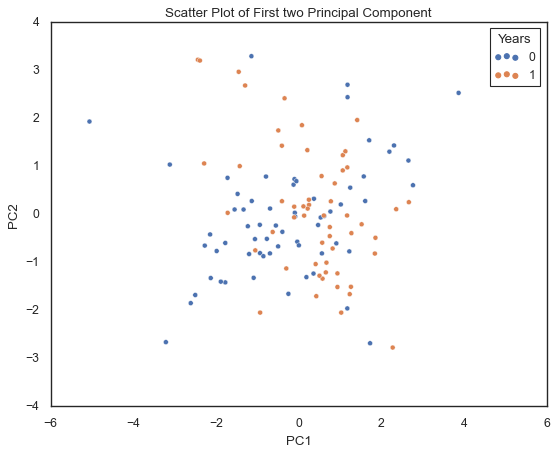

In [99]:
plt.figure()
sns.scatterplot(x=X1[:,0],y=X1[:,1], hue=Y, palette='deep')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Scatter Plot of First two Principal Component')

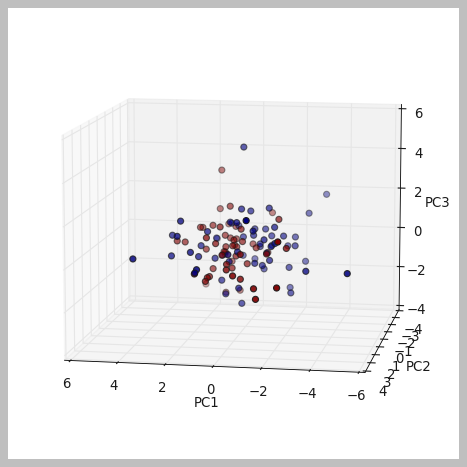

In [100]:
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('classic')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1[:,0],X1[:,1], X1[:,2], c=df.Years, s=30)
ax.view_init(10,100)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.tight_layout()
plt.show()

In [101]:
seed = 7
test_size = 0.2
strategy = 'most_frequent'

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=test_size, random_state=seed)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (96, 11)
Shape of X_test: (24, 11)


# Dummy classifier

In [102]:
dum = DummyClassifier(strategy=strategy)
dum = dum.fit(X_train, y_train)

# Accuracy

In [103]:
score = dum.score(X_test, y_test)
print(f"Dummy Classifier Accuracy: {score*100:.2f}")

Dummy Classifier Accuracy: 45.83


Text(0, 0.5, 'Frequency')

<Figure size 560x560 with 0 Axes>

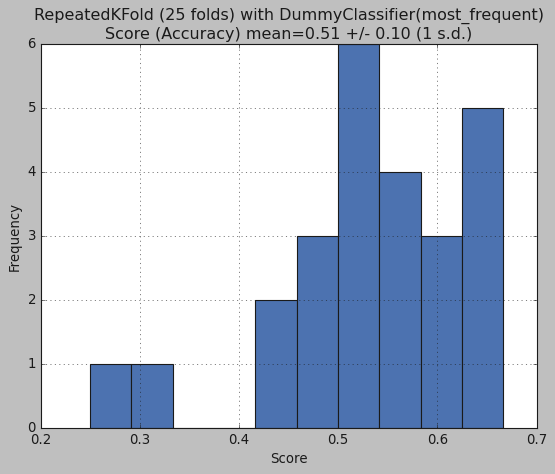

In [104]:
scores = cross_val_score(
       dum, 
       X, 
       Y,
       cv=RepeatedKFold(n_repeats=CV_N_REPEATS),
       scoring=None)
scores_dummy = scores.copy()

score_line = f"Score (Accuracy) mean={scores.mean():.2f} +/- {scores.std():.2f} (1 s.d.)"

plt.figure(figsize=(7,7))
fig, ax = plt.subplots()
pd.Series(scores).hist(ax=ax, bins=BINS)
ax.set_title(f"RepeatedKFold ({len(scores)} folds) with DummyClassifier({strategy})\n"+score_line)
ax.set_xlabel("Score")
ax.set_ylabel("Frequency")

# Helper function for graphical plotting of decision tree and plot confussion matrix

In [105]:
def plot_tree_graph(model, columns, class_name):
       dot_data = export_graphviz(model, feature_names=columns, class_names=class_name)
       graph = graphviz.Source(dot_data)
       return graph

In [106]:
def confusion_mat(y_pred, y_test):
       plt.figure()
       sns.set(font_scale=1.5)
       cm = confusion_matrix(y_pred, y_test)
       sns.heatmap(cm, annot=True, fmt="g")
       plt.title("Confusion matrix", y=1.1)
       plt.ylabel("Actual label")
       plt.xlabel("Predicted label")
       plt.show()

# K-Nearest Neighbors

In [107]:
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=11)

# Accuracy

In [108]:
scores = cross_val_score(
       knn, 
       X, 
       Y,
       cv=RepeatedStratifiedKFold(n_repeats=CV_N_REPEATS))

print(f"Accuracy mean={scores.mean():.2f} +/- {scores.std():.2f} (1 s.d.)")

Accuracy mean=0.73 +/- 0.07 (1 s.d.)


# Decision Tree

In [109]:
dt = DecisionTreeClassifier(random_state=1, max_depth=2)
dt = dt.fit(X_train, y_train)

# Accuracy

In [110]:
scores = cross_val_score(
       dt, 
       X, 
       Y,
       cv=RepeatedStratifiedKFold(n_repeats=CV_N_REPEATS))

print(f"Accuracy mean={scores.mean():.2f} +/- {scores.std():.2f} (1 s.d.)")

Accuracy mean=0.72 +/- 0.06 (1 s.d.)


In [111]:
# plt.figure()
# graph = plot_tree_graph(df, X.columns, ['0','1'])

# Bagging Classifier

In [112]:
bag = BaggingClassifier(n_estimators=100, oob_score=True)
bag = bag.fit(X_train, y_train)

# Accuracy

In [113]:
scores = cross_val_score(
       bag, 
       X, 
       Y,
       cv=RepeatedStratifiedKFold(n_repeats=CV_N_REPEATS))

print(f"Accuracy mean={scores.mean():.2f} +/- {scores.std():.2f} (1 s.d.)")
print(f"Out of bag score: {bag.oob_score_*100:.2f}")

Accuracy mean=0.78 +/- 0.09 (1 s.d.)
Out of bag score: 78.12


# Random Forest

In [114]:
num_estimators=100
rf = RandomForestClassifier(n_estimators=num_estimators)
rf.fit(X_train, y_train)

RandomForestClassifier()

# Accuracy

In [115]:
scores = rf.score(X_test, y_test)

print(f"Accuracy of Random Forest {scores*100}")

Accuracy of Random Forest 83.33333333333334


# Predictions

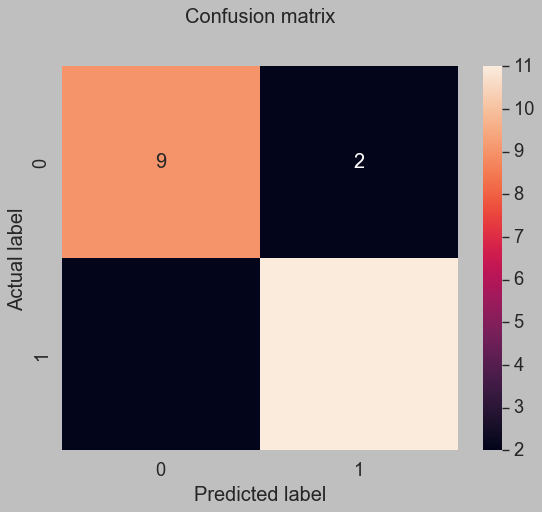

In [116]:
y_pred = rf.predict(X_test)
confusion_mat(y_pred, y_test)

# Feature importance with eli5

In [117]:
feature_names = df.columns.values[:11]
show_weights(rf, feature_names=feature_names)

Weight,Feature
0.2370 ± 0.3647,SiO4Si
0.1166 ± 0.1899,NO3N
0.1077 ± 0.1988,SRP
0.0844 ± 0.1700,DINtoDIP
0.0830 ± 0.1632,NH4N
0.0780 ± 0.1609,PP
0.0644 ± 0.1639,TN/TP
0.0628 ± 0.1305,DON
0.0623 ± 0.1521,Fe
0.0564 ± 0.1506,DOP


# Checking variance in RF prediction quality

Text(0, 0.5, 'Frequency')

<Figure size 640x480 with 0 Axes>

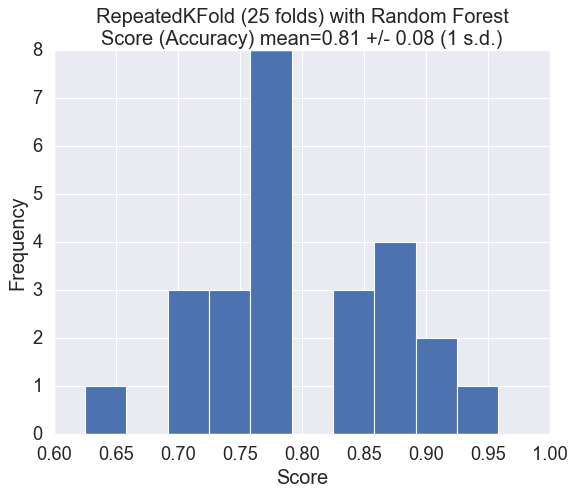

In [118]:
scores = cross_val_score(
       rf, 
       X, 
       Y,
       cv=RepeatedStratifiedKFold(n_repeats=CV_N_REPEATS))
scores_est = scores.copy()

score_line = f"Score (Accuracy) mean={scores.mean():.2f} +/- {scores.std():.2f} (1 s.d.)"

plt.figure()
fig, ax = plt.subplots()
pd.Series(scores).hist(ax=ax, bins=BINS)
ax.set_title(f"RepeatedKFold ({len(scores)} folds) with Random Forest\n"+score_line)
ax.set_xlabel("Score")
ax.set_ylabel("Frequency")

# Comparizon of prediction performance of Random Forest Classifier and Dummy Classifier

Text(0.5, 1.0, 'Dummy vs Random Forest Scores')

<Figure size 640x480 with 0 Axes>

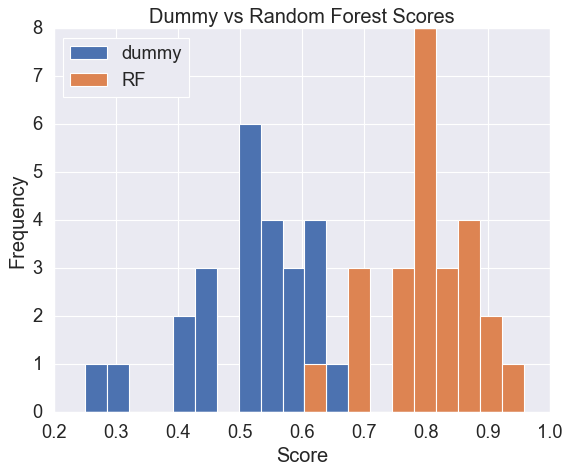

In [119]:
plt.figure()
fig, ax = plt.subplots()
df_dummy_est_scores = pd.DataFrame({'dummy':scores_dummy,'RF':scores_est})
df_dummy_est_scores.plot(kind='hist', ax=ax, bins=20)
ax.set_xlabel("Score")
ax.set_title("Dummy vs Random Forest Scores")

# Gradient Boosting Classifier

In [120]:
from sklearn.metrics import mean_squared_error
params = {"n_estimators":500, "learning_rate":0.01, "max_depth":4,"loss":"log_loss"}

gbm = GradientBoostingClassifier(**params)
gbm.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=4, n_estimators=500)

## Compute test set log_loss

In [121]:
test_score = np.zeros((params["n_estimators"],),dtype=np.float64)

for i, y_pred in enumerate(gbm.staged_predict_proba(X_test)):
       test_score[i] = log_loss(y_test, y_pred)
# oryginalne
# for i, y_pred in enumerate(gbm.staged_predict(X_test)):
       # test_score[i] = gbm.loss_(y_test, y_pred)

## Plot

Text(0, 0.5, 'Log Loss')

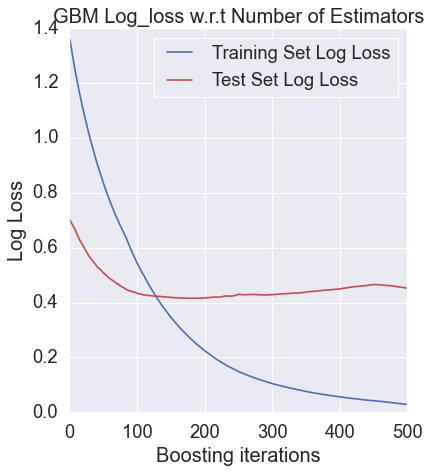

In [122]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("GBM Log_loss w.r.t Number of Estimators")
plt.plot(np.arange(params["n_estimators"])+1, gbm.train_score_, 'b-', label="Training Set Log Loss")
plt.plot(np.arange(params["n_estimators"])+1, test_score, 'r-', label="Test Set Log Loss")
plt.legend(loc='best')
plt.xlabel("Boosting iterations")
plt.ylabel("Log Loss")

In [123]:
params = {"n_estimators":100, "learning_rate":0.01, "max_depth":4,"loss":"log_loss"}

gbm = GradientBoostingClassifier(**params)
gbm.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=4)

## Predictions

In [124]:
y_pred = gbm.predict(X_test)

gbm_score = accuracy_score(y_test, y_pred)
print(f"Accuracy of GBM Classifier: {gbm_score*100:.2f}")

Accuracy of GBM Classifier: 91.67


## Confusion matrix plot

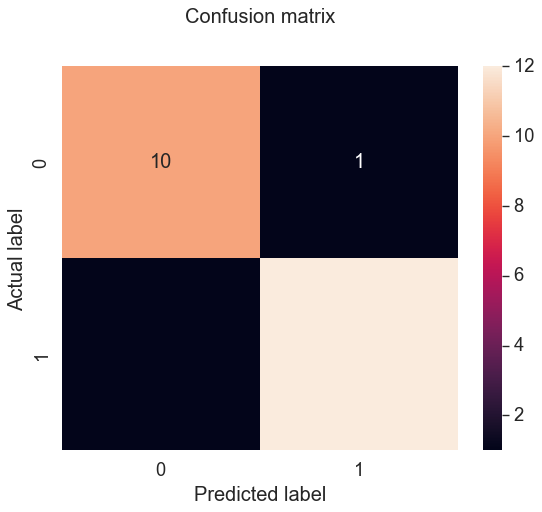

In [125]:
confusion_mat(y_pred, y_test)

## Feature importance

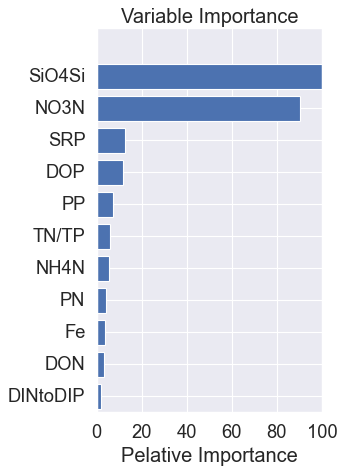

In [126]:
feature_importance = gbm.feature_importances_
feature_importance = 100* (feature_importance/feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])+.5
plt.subplot(1,2,2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df.columns[sorted_idx])
plt.xlabel("Pelative Importance")
plt.title("Variable Importance")
plt.show()

# XgBoost

In [127]:
from xgboost import XGBClassifier, plot_importance, to_graphviz

param = {'max_depth':3, 'eta':0.8, 'subsample':1, 'objective':'binary:logistic'}
xgb = XGBClassifier(**param)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.8, eval_metric=None,
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, ...)

## Predictions

Accuracy of XGB Classifier: 75.00


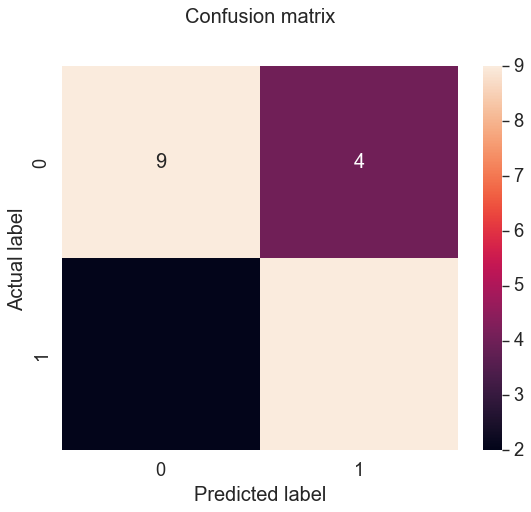

In [128]:
y_pred = xgb.predict(X_test)

xgb_score = accuracy_score(y_test, y_pred)
print(f"Accuracy of XGB Classifier: {xgb_score*100:.2f}")
confusion_mat(y_pred, y_test)

<Figure size 640x480 with 0 Axes>

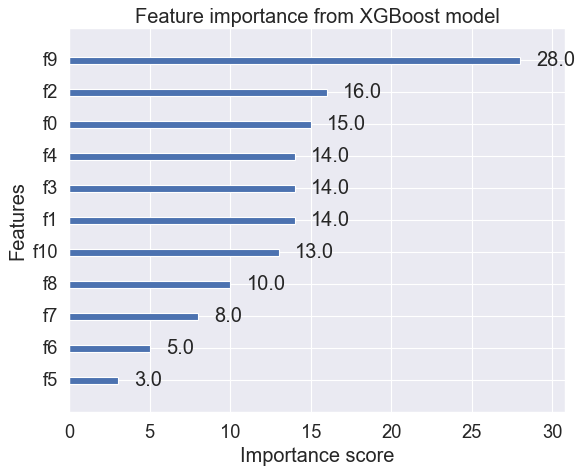

In [129]:
plt.figure()
plot_importance(xgb, title="Feature importance from XGBoost model")
plt.show()

# Voting Classifier

In [130]:
from sklearn.ensemble import VotingClassifier

ensemble_knn_rf_xgb=VotingClassifier(estimators=[('KNN', knn), ('Random Forest', rf), ('XGBoost', xgb)], voting='hard')
ensemble_knn_rf_xgb.fit(X_train, y_train)

VotingClassifier(estimators=[('KNN', KNeighborsClassifier(n_neighbors=11)),
                             ('Random Forest', RandomForestClassifier()),
                             ('XGBoost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False, eta=0.8,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None, ...))])

## Accuracy

In [131]:
print(f"The ensembled model with all the 3 classifiers is: {ensemble_knn_rf_xgb.score(X_test, y_test)}")

The ensembled model with all the 3 classifiers is: 0.7083333333333334


## Predictions

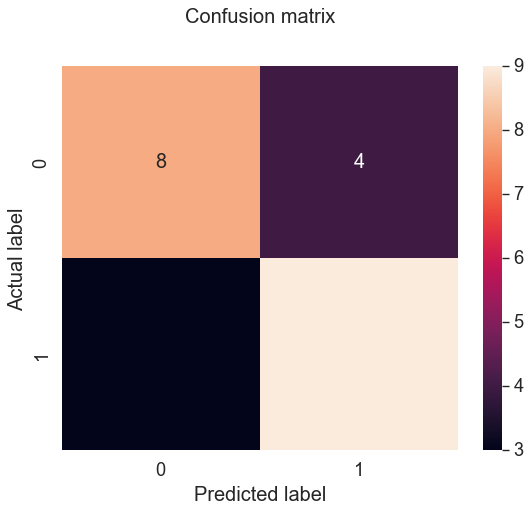

In [132]:
y_pred = ensemble_knn_rf_xgb.predict(X_test)
confusion_mat(y_pred, y_test)

# Stacking

In [133]:
from mlxtend.classifier import StackingCVClassifier

sclf = StackingCVClassifier(classifiers=[knn, rf, xgb, gbm],
                            meta_classifier=rf)
print('10-fold cross validation:\n')

10-fold cross validation:


In [134]:
for clf, label in zip([knn, rf, xgb, gbm, rf],[
       'KNearest Neighbors',
       'Random Forest',
       'XGB',
       'GBM',
       'MetaClassifier'
]):
       sclf_scores = model_selection.cross_val_score(
              clf, X, Y, cv=10, scoring='accuracy'
       )
       print(f"Accuracy: {sclf_scores.mean():.2f} (+/- {sclf_scores.std():.2f}) [{label}]")

Accuracy: 0.65 (+/- 0.15) [KNearest Neighbors]
Accuracy: 0.76 (+/- 0.18) [Random Forest]
Accuracy: 0.78 (+/- 0.17) [XGB]
Accuracy: 0.70 (+/- 0.14) [GBM]
Accuracy: 0.79 (+/- 0.17) [MetaClassifier]


# Result summary

In [135]:
models = []
models.append(('KNN',knn))
models.append(('DT',dt))
models.append(('RF',rf))
models.append(('GBM',gbm))
models.append(('XGB',xgb))
models.append(('Voting',ensemble_knn_rf_xgb))

## testing all algorithms and collecting the result

In [136]:
results = []
names = []

for name, model in models:
       kfold = model_selection.StratifiedKFold(n_splits=10, random_state=7, shuffle=True)
       cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring="accuracy")
       results.append(cv_results)
       names.append(name)
       msg = f"{name}:{cv_results.mean()} ({cv_results.std()})"
       print(msg)

KNN:0.7666666666666667 (0.09718253158075502)
DT:0.6916666666666667 (0.09895285072531597)
RF:0.8083333333333333 (0.09895285072531598)
GBM:0.7250000000000001 (0.09166666666666667)
XGB:0.7833333333333333 (0.1130388330520878)
Voting:0.7916666666666667 (0.08539125638299665)


## Add stacking results that we got previously

In [137]:
results.append(np.asarray(sclf_scores))
names.append('Stacking')

## Boxplot algorithm comparison 

### Neither the `x` nor `y` variable appears to be numeric.

In [138]:
# fig = plt.figure(figsize=(10,6))
# fig.suptitle("Algorithm Comparison")
# ax = sns.boxplot(x=names, y=results)
# plt.xlabel("Classifiers")
# plt.ylabel("Accuracy")
# plt.show()

In [139]:
df_results = pd.DataFrame({
    "Model": np.repeat(names, [len(r) for r in results]),
    "Accuracy": np.concatenate(results)
})

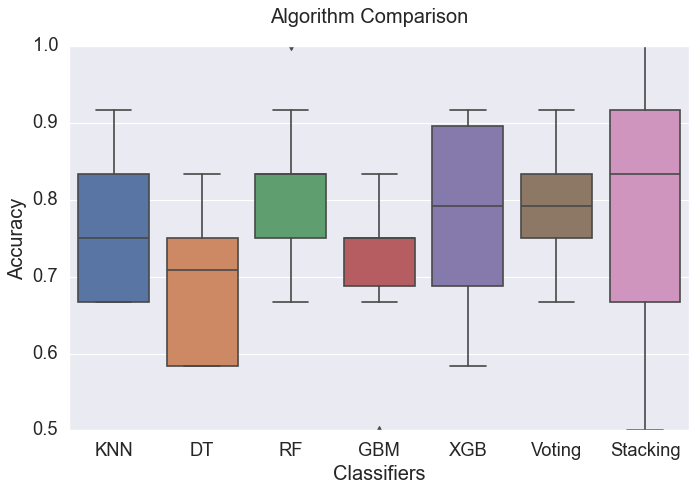

In [140]:
fig = plt.figure(figsize=(10,6))
fig.suptitle("Algorithm Comparison")
ax = sns.boxplot(x="Model", y="Accuracy", data=df_results)
plt.xlabel("Classifiers")
plt.ylabel("Accuracy")
plt.show()

# Classifier report

## XGB Classifier

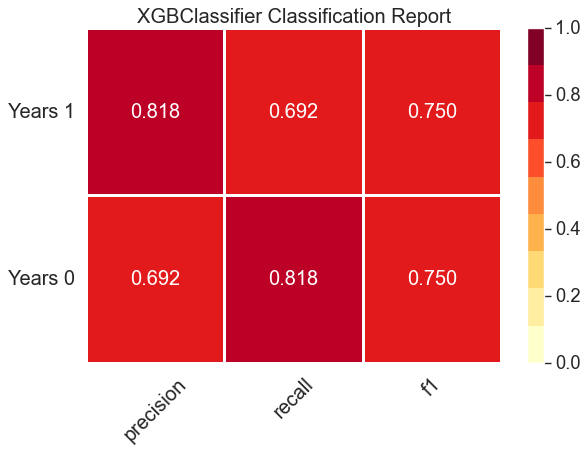

<Axes: title={'center': 'XGBClassifier Classification Report'}>

In [141]:
visualizer = ClassificationReport(xgb, classes=["Years 0", "Years 1"])
# visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

## Voting Classifier

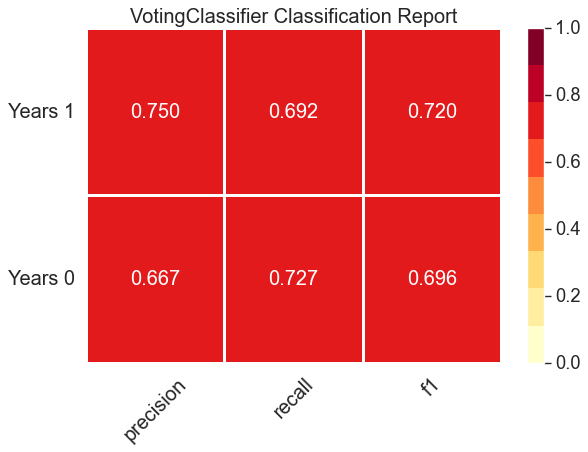

<Axes: title={'center': 'VotingClassifier Classification Report'}>

In [142]:
visualizer = ClassificationReport(ensemble_knn_rf_xgb, classes=["Years 0", "Years 1"])
# visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()